In [1]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import os

from photutils import aperture_photometry, CircularAperture, CircularAnnulus

from astropy.io import fits
from astropy.nddata import CCDData
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

from scipy.stats import t as t 
from scipy.constants import *

from uncertainties import *
from uncertainties.unumpy import *
from uncertainties.umath import *

/tmp/ipykernel_39681/3769014535.py:9: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/tmp/ipykernel_39681/3769014535.py:9: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/tmp/ipykernel_39681/3769014535.py:9: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this wa

In [2]:
# Define the object and filter
object = 'OJ_287'
filter = 'B'

In [3]:
# Constants and values
d = 0.5 #m
z = 0.306 

L_sun = 3.828e33 #erg/s

In [4]:
# Importing data
B_mag = pd.read_csv('data/B_mag.csv')
filters = pd.read_csv('data/filters.csv')

In [5]:
# File paths
bias_files = glob.glob('data/bias/*.fits')
dark_files = glob.glob('data/dark/*.fits')
flat_files = glob.glob(f'data/flat/{filter}/*.fits')
obs_files = glob.glob(f'{object}/{filter}/*.fits')

In [6]:
def create_master_frame(file_list, master_type="bias"):
    # Load all files and stack them
    image_stack = [CCDData.read(file, unit="adu") for file in file_list]
    # Combine images by averaging
    if master_type == "bias" or master_type == "flat":
        master_frame = np.mean([image.data for image in image_stack], axis=0)
        master_filename = f"master/{master_type}.fits"
        fits.writeto(master_filename, master_frame, overwrite=True)
    elif master_type == "dark":
        master_frame = np.median([image.data for image in image_stack], axis=0)
        master_filename = f"master/{master_type}.fits"
        fits.writeto(master_filename, master_frame, overwrite=True)
    elif master_type == "flat":
        master_frame = np.mean([image.data for image in image_stack], axis=0)
        master_filename = f"master/{master_type}_{filter}.fits"
        fits.writeto(master_filename, master_frame, overwrite=True)

    return master_frame, master_filename

def apply_calibration(obs_file, master_bias, master_dark, master_flat):
    # Read the observation file
    with fits.open(obs_file) as hdul:
        obs_data = hdul[0].data
        header = hdul[0].header
        
        # Calibrate the data
        calibrated_data = ((obs_data - master_bias - master_dark) / master_flat) * np.median(master_flat)
        
        # Update header to indicate processing
        header['HISTORY'] = 'Calibrated using custom script with master frames'
        
        # Write the calibrated data to a new FITS file
        calibrated_filename = f"{object}/proc/{filter}/calibrated_{os.path.basename(obs_file)}"
        fits.writeto(calibrated_filename, calibrated_data, header, overwrite=True)
        return calibrated_filename

def merge_fits(files, output_filename=f"{object}/proc/{object}_{filter}_merged.fits"):
    # Assuming all images are the same size
    master_data = np.sum([fits.getdata(file) for file in files], axis=0)
    header = fits.getheader(files[0])  # Use the header of the first file
    fits.writeto(output_filename, master_data, header, overwrite=True)

# Function to perform aperture photometry
def measure_brightness(image, positions, aperture_radius, annulus_inner_radius, annulus_outer_radius):
    apertures = CircularAperture(positions, r=aperture_radius)
    annuli = CircularAnnulus(positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    phot_table = aperture_photometry(image, apertures)
    background_phot_table = aperture_photometry(image, annuli)
    
    # Calculating the mean background per pixel in the annulus
    background_mean = background_phot_table['aperture_sum'] / annuli.area
    
    # Calculating the total background within the aperture to subtract
    background_sum = background_mean * apertures.area
    
    # Subtraction of the background to get the net star brightness
    net_brightness = phot_table['aperture_sum'] - background_sum

    # Error estimation
    # Photon noise (Poisson noise) for the aperture and annulus
    phot_error = np.sqrt(np.abs(phot_table['aperture_sum']))
    background_error = np.sqrt(np.abs(background_phot_table['aperture_sum']))
    
    background_mean_error = background_error / np.sqrt(annuli.area)
    background_sum_error = background_mean_error * apertures.area
    
    net_brightness_error = np.sqrt(phot_error**2 + background_sum_error**2)

    return net_brightness, net_brightness_error

def redshift_to_distance(z):
    d_mpc = cosmo.comoving_distance(z)
    d_meters = d_mpc.to(u.m)
    
    return d_meters.value

def luminosity(counts, exp_time, filter='B'):
    if filter == 'B':
        lam = filters[filters['filter'] == 'B']['lam'].values[0]
    if filter == 'V':
        lam = filters[filters['filter'] == 'V']['lam'].values[0]

    F = (counts*h*c/lam) / (exp_time*np.pi*d**2) * 10**7 #erg/s/cm^2

    L = 4*np.pi*(redshift_to_distance(z)**2)*F #erg/s

    return F, L

# Function to calculate the uncertainty of mean value
def uncert(data_input, uncert_inst):
    t_coeff = t.ppf((1 + 0.6827)/2, len(data_input)-1)
    return np.sqrt((np.std(data_input)/np.sqrt(len(data_input)))**2 + uncert_inst**2)*t_coeff

In [7]:
# Create master frames
master_bias, bias_filename = create_master_frame(bias_files, "bias")
master_dark, dark_filename = create_master_frame(dark_files, "dark")
master_flat, flat_filename = create_master_frame(flat_files, "flat")

In [8]:
# Calibrating images
calibrated_files = [apply_calibration(file, master_bias, master_dark, master_flat) for file in obs_files]

In [9]:
# Merge all calibrated files
# merge_fits(calibrated_files)

In [10]:
# Loading images
image_paths = glob.glob(f"{object}/proc/{filter}/*.fits")
image_paths.sort()

images = [fits.getdata(image_path) for image_path in image_paths]

exposure_times = []
for image_path in image_paths:
    with fits.open(image_path) as hdul:
        exposure_time = hdul[0].header['EXPTIME']
        exposure_times.append(exposure_time)

In [11]:
# Positions of your stars [x, y] and aperture radius
positions = [(1191.6298, 1040.9592), (1086.6589, 994.2256), (1129.1985, 991.3497), (1039.8204, 1084.1038)]  # Positions for 3 comparison stars and 1 object

# Aperture and annulus radii
aperture_radius = 9  
annulus_inner_radius = 16
annulus_outer_radius = 25

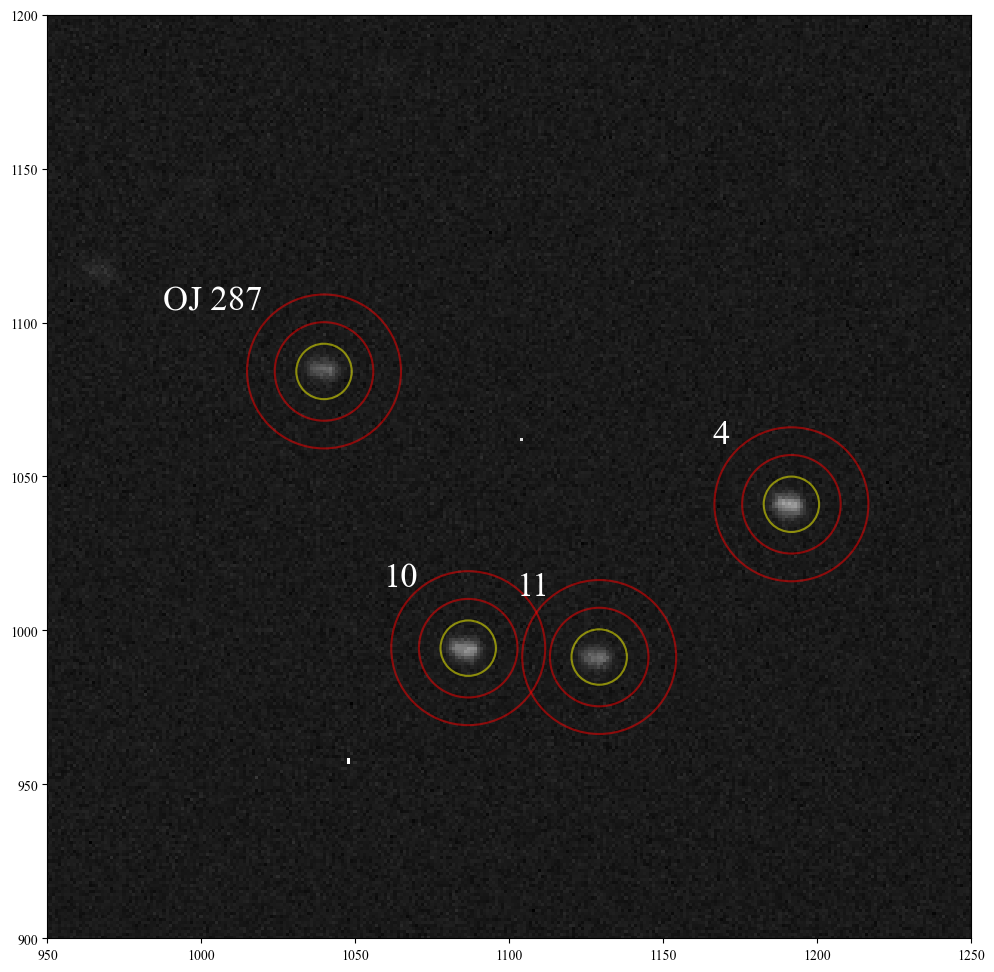

In [12]:
# Plot the image
plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"

image_example = images[0]

vmin = -281.2111
vmax= 1431.3306

apertures = CircularAperture(positions, r=aperture_radius)
annuluses = CircularAnnulus(positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)


plt.figure(figsize=(10, 10))
plt.imshow(image_example, cmap='gray', vmin=vmin, vmax=vmax)

plt.xlim(950, 1250) 
plt.ylim(900, 1200)  

apertures.plot(color='yellow', lw=1.5, alpha=0.5)
annuluses.plot(color='red', lw=1.5, alpha=0.5)

plt.annotate('4', (positions[0][0]-20, positions[0][1]+20), color='white', fontsize=25, ha='right')
plt.annotate('10', (positions[1][0]-16, positions[1][1]+20), color='white', fontsize=25, ha='right')
plt.annotate('11', (positions[2][0]-16, positions[2][1]+20), color='white', fontsize=25, ha='right')
plt.annotate('OJ 287', (positions[3][0]-20, positions[3][1]+20), color='white', fontsize=25, ha='right')

plt.tight_layout()  
plt.savefig('images/apertures.png')

plt.show()

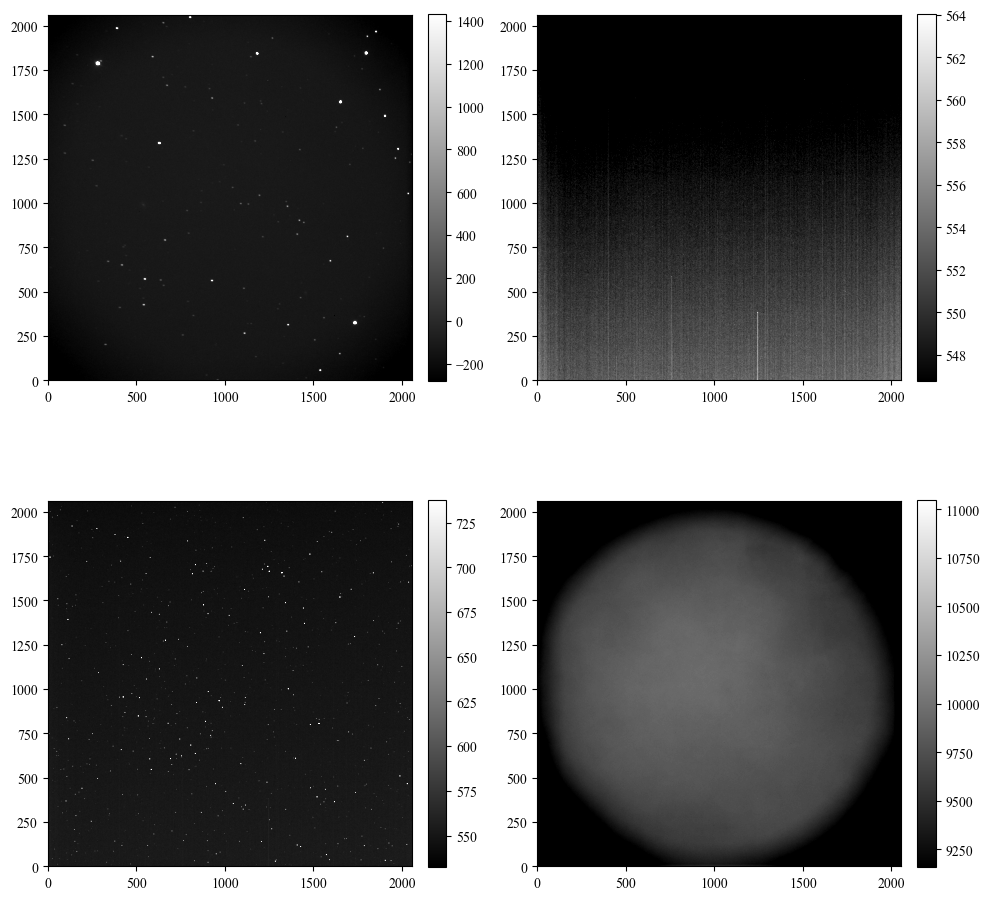

In [13]:
# Plotting master and calibrated pictures
fits_files = [calibrated_files[0], bias_filename, dark_filename, flat_filename]
fits_img = [fits.getdata(fits_file) for fits_file in fits_files]

v_list = [(-281.2111, 1431.3306), (546.7800, 564.0176), (532.4324, 737.4638), (9160.1622, 11045.6924)]

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(fits_img[i], cmap='gray', vmin=v_list[i][0], vmax=v_list[i][1], origin='lower')
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('images/fits.png')

plt.show()

In [14]:
# Calculating magnitude of the object
mag_comparisons = [ufloat(15.01, 0.06), ufloat(15.01, 0.05), ufloat(15.47, 0.07)]  # Example magnitudes for the 3 comparison stars

mag_list = [[] for _ in mag_comparisons]

for image in images:
    net_brightness, net_brightness_err = measure_brightness(image, positions, aperture_radius, annulus_inner_radius, annulus_outer_radius)
        
    for i, mag_comparison in enumerate(mag_comparisons):
        # Calibrate variable star magnitude based on each comparison star
        mag_obj = mag_comparison - 2.512*(log10(ufloat(net_brightness[-1], net_brightness_err[-1]) / ufloat(net_brightness[i], net_brightness_err[i])))
        mag_list[i].append(mag_obj)

mag_mean = ufloat(np.mean(nominal_values(mag_list)), uncert(nominal_values(mag_list), np.mean(std_devs(mag_list))))
print(f"Mean magnitude: {mag_mean}")

mag_diff = 15.91 - mag_mean
print(f"Difference in magnitude: {mag_diff}")


Mean magnitude: 15.61+/-0.21
Difference in magnitude: 0.30+/-0.21


In [15]:
# Calculating luminosity of the object

from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

for exposure in exposure_times:
    F, L = luminosity(ufloat(net_brightness[-1], net_brightness_err[-1]), exposure)
    print(f"Flux: {F:.2e} [erg/s/m^2]")
    print(f"Luminosity: {L:.2e} [erg/s]")
    
    print(f"Luminocity in solar units: {L/L_sun:.2e} [L_sun]")

Flux: (1.17+/-0.12)e-09 [erg/s/m^2]
Luminosity: (2.21+/-0.24)e+43 [erg/s]
Luminocity in solar units: (5.77+/-0.61)e+09 [L_sun]


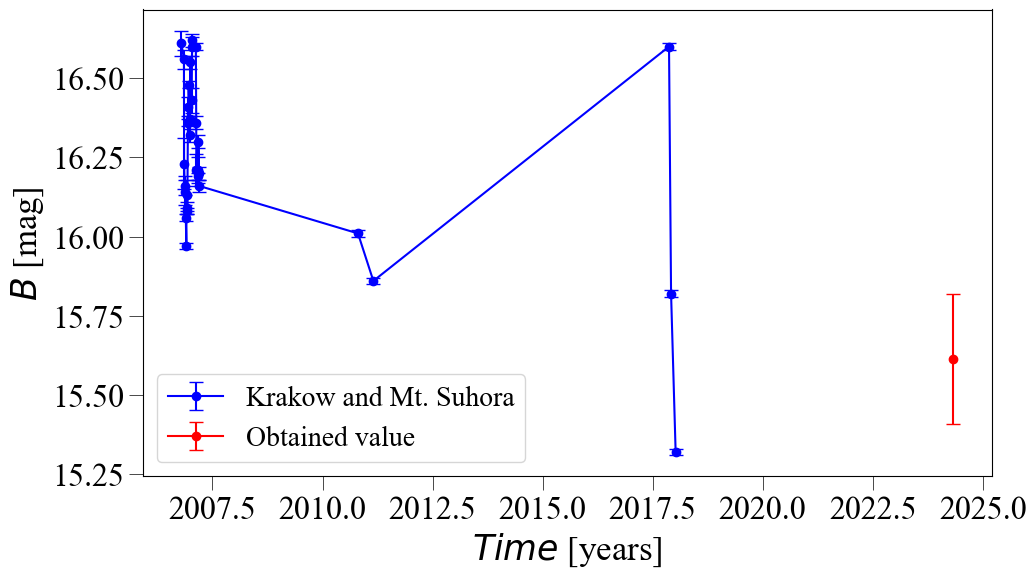

In [16]:
# Plot of B magnitude vs time
ax_l_size = 25
l_size = 23

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel(r"$Time$ [years]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$B$ [mag]")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.errorbar(B_mag['year'], B_mag['mag'], yerr=B_mag['mag_err'], fmt='o-', color='blue', capsize=5, label='Krakow and Mt. Suhora')
ax.errorbar(2024.3306, mag_mean.nominal_value, yerr=mag_mean.std_dev, fmt='o-', color='red', capsize=5, label='Obtained value')

ax.legend(loc='lower left', fontsize=20)

plt.show() 

fig.savefig('images/B.png', bbox_inches='tight')